In [41]:
! pip install numpy pandas scikit-learn catboost matplotlib seaborn phik nltk wordcloud imblearn tensorflow

## Поменять

✅Ты делаешь токенизацию текстов, во первых хочется видеть более детальный анализ токенов (помимо облака слов еще диаграммы), проверка пунктуации. Во вторых токенизация для EDA и для модели должна быть одинаковая, иначе анализируешь ты одно, а на вход модели передается другое совсем, в чем нет смысла

✅Также токенизатор должен корректно работать с oov_token

✅Проверь что везде SEED фиксированный используется, чтобы нейронки обучались всегда одинаково для одних и тех же данных

✅Длина последовательностей = максимуму. Максимум часто определяется редкими хвостами → перерасход вычислений и регуляризации. Возьми, например, 95-й перцентиль длины

❓Нет стратификации при сплите train_test_split без stratify=y. Даже при балансе классов это повышает дисперсию метрик.

✅В первой LSTM у тебя Embedding(..., trainable=False) без загруженной матрицы — фактически «замороженная случайная» эмбеддинг-матрица. В этом нет смысла. Либо ты обучаешь эмбеддинги, либо используешь предобученные

✅Круто что ты нашел такую зависимость между 'subject' и 'target', для этого как раз графики и строятся, чтобы такое вот находить. В этом случае нам мл модель вообще не нужна, мы можем таргет предсказывать просто по subject и все, правильно что выкинул

✅Кажется, у тебя утечка данных при использовании
X_train_text = vectorizer.fit_transform(X_train['text'].fillna(''))
X_test_text = vectorizer.fit_transform(X_test['text'].fillna(''))
CountVectorizer должен быть частью пайплайна

✅В реальных задачах ты никогда не будешь выкидывать текст статьи и оставлять только заголовок, поэтому используй сразу оба столбца

✅У каждой модели хотелось бы посмотреть важности признаков, а именно токенов, ведь это самое главное в текстовой классификации: увидеть какие слова влияют в какую сторону.

✅Добавь еще f1 метрику

Тюнинг гиперпараметров советую потренировать на нейронках, там их как раз много. Будет долго обучаться, но для тренировки стоит сделать

❓Еще общее замечание: код очень хаотичный и трудно разобрать, что зачем происходит. Старайся делить его на блоки и описывать что за чем происходит и логику своих действий, почему ты делаешь то или иное действие

✅Еще тебе нужно разбить данные по времени, то есть в test самые свежие новости, в train более ранние

✅Еще вспомнил, попробуй CNN использовать. Эта штука очень быстро обучается и точность высокая

## Начало

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from helper import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from plots import *
import re

In [43]:
SEED = 42

In [44]:

def split_dataset(path, target_value, date_col='date', target_col='target', ratio=0.8): # т.к. датасет лежит в 2 файлах и надо в тест взять самые новые новости приходится выкручиваться
    df = pd.read_csv(path)
    df[target_col] = target_value  # ставим таргет
    df = df.sort_values(date_col).reset_index(drop=True)
    split_idx = int(len(df) * ratio)

    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]

    X_train = train.drop(columns=[target_col])
    y_train = train[target_col]
    X_test = test.drop(columns=[target_col])
    y_test = test[target_col]

    return X_train, X_test, y_train, y_test

# true = класс 1, false = класс 0
X_train_true, X_test_true, y_train_true, y_test_true = split_dataset('True.csv', target_value=1) # отдельно сплитим каждый датасет таким образом, что в тест попали самые свежие
X_train_false, X_test_false, y_train_false, y_test_false = split_dataset('Fake.csv', target_value=0)

# объединяем
X_train = pd.concat([X_train_true, X_train_false], ignore_index=True)
y_train = pd.concat([y_train_true, y_train_false], ignore_index=True)
X_test = pd.concat([X_test_true, X_test_false], ignore_index=True)
y_test = pd.concat([y_test_true, y_test_false], ignore_index=True)

# X_train['combo'] = X_train['title'] + X_train['text']
# X_test['combo'] = X_test['title'] + X_test['text']

# финальное распределение
print('Train distribution:\n', y_train.value_counts(normalize=True))
print('Test distribution:\n', y_test.value_counts(normalize=True))

Train distribution:
 target
0    0.522984
1    0.477016
Name: proportion, dtype: float64
Test distribution:
 target
0    0.522993
1    0.477007
Name: proportion, dtype: float64


In [45]:
X_train.head(10)

,title,text,subject,date
0,Trump sued in Kentucky by three who say he inc...,"LOUISVILLE, Ky. (Reuters) - Three people who c...",politicsNews,"April 1, 2016"
1,"In record year for political ads, media buyers...",(Reuters) - Media buyers expect record politic...,politicsNews,"April 1, 2016"
2,"Obama, Republicans urge Trump to soften tone",WASHINGTON (Reuters) - Donald Trump is facing ...,politicsNews,"April 1, 2016"
3,State Department says halts review of Clinton ...,WASHINGTON (Reuters) - The U.S. State Departme...,politicsNews,"April 1, 2016"
4,Obama: Trump doesn't know much about foreign p...,WASHINGTON (Reuters) - U.S. President Barack O...,politicsNews,"April 1, 2016"
5,Obama says 'no doubt' civilians have been kill...,WASHINGTON (Reuters) - U.S. President Barack O...,politicsNews,"April 1, 2016"
6,Former New York deputy secretary of state accu...,NEW YORK (Reuters) - A former New York deputy ...,politicsNews,"April 1, 2016"
7,Hillary Clinton to propose $10 billion manufac...,WASHINGTON (Reuters) - Democratic presidential...,politicsNews,"April 1, 2016"
8,Trump's probability of winning nomination drop...,NEW YORK (Reuters) - The probability that Repu...,politicsNews,"April 1, 2016"
9,Senator Warren seeks investigation of insurers...,WASHINGTON (Reuters) - Senator Elizabeth Warre...,politicsNews,"April 1, 2016"


In [46]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED, shuffle=True, stratify=None)

# X_train.drop(columns=['subject', 'date', 'text', 'title'], inplace=True)
# X_test.drop(columns=['subject', 'date', 'text', 'title'], inplace=True)
# X_val.drop(columns=['subject', 'date', 'text', 'title'], inplace=True)

X_train.drop(columns=['subject', 'date'], inplace=True) # удаляем неинформативные колонки
X_test.drop(columns=['subject', 'date'], inplace=True)
X_val.drop(columns=['subject', 'date'], inplace=True)

X_train.head(10)

,title,text
0,Trump sued in Kentucky by three who say he inc...,"LOUISVILLE, Ky. (Reuters) - Three people who c..."
1,"In record year for political ads, media buyers...",(Reuters) - Media buyers expect record politic...
2,"Obama, Republicans urge Trump to soften tone",WASHINGTON (Reuters) - Donald Trump is facing ...
3,State Department says halts review of Clinton ...,WASHINGTON (Reuters) - The U.S. State Departme...
4,Obama: Trump doesn't know much about foreign p...,WASHINGTON (Reuters) - U.S. President Barack O...
5,Obama says 'no doubt' civilians have been kill...,WASHINGTON (Reuters) - U.S. President Barack O...
6,Former New York deputy secretary of state accu...,NEW YORK (Reuters) - A former New York deputy ...
7,Hillary Clinton to propose $10 billion manufac...,WASHINGTON (Reuters) - Democratic presidential...
8,Trump's probability of winning nomination drop...,NEW YORK (Reuters) - The probability that Repu...
9,Senator Warren seeks investigation of insurers...,WASHINGTON (Reuters) - Senator Elizabeth Warre...


In [47]:
len(X_val), len(X_test)

(4490, 4491)

блок для тестов

In [48]:
# def preprocessing(text):
#      text = text.lower()
#      text = re.sub('[^a-zA-Z]', ' ', text)
#      text = re.sub('\s+', ' ', text)
#      text = re.sub(r'https?://\S+|www\.\S+|[^a-zA-Z\s]', '', text)
#      text = re.sub(r'<.*?>', '', text)
#      return text

# vectorized = np.vectorize(preprocessing)
# x_train = vectorized(X_train)
# x_test = vectorized(X_test)
# x_val = vectorized(X_val)

# print('the first 20 words of first train text after preprocessing:')
# visualize = ''
# counter = 0

# for i in x_train[0].split(' '):
#     visualize = visualize + i + " "
#     if counter>20:
#         break
#     counter = counter + 1

# print(visualize)

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(x_train)

# train_seq = tokenizer.texts_to_sequences(x_train)
# test_seq = tokenizer.texts_to_sequences(x_test)
# val_seq = tokenizer.texts_to_sequences(x_val)
# vocab_size = len(tokenizer.word_index) + 1
# max_length = max(len(sequence) for sequence in train_seq)

# train_seq = pad_sequences(train_seq, maxlen = max_length, padding = 'post', truncating = 'post')
# test_seq = pad_sequences(test_seq, maxlen = max_length, padding = 'post', truncating = 'post')
# val_seq = pad_sequences(val_seq, maxlen = max_length, padding = 'post', truncating = 'post')

## Preprocessing

In [49]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
from pipeline import CustomPipeline
import nltk


nltk.download('stopwords')
from nltk.corpus import stopwords

pipeline = CustomPipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
train_seq = pipeline.fit_transform(X_train) # применяем пайплайн
val_seq = pipeline.transform(X_val)
test_seq = pipeline.transform(X_test)

vocab_size = pipeline.named_steps['tokenizer'].vocab_size
max_length = pipeline.named_steps['tokenizer'].max_length

vocab_size, max_length

(98497, 4989)

In [52]:
train_seq

array([[   2, 2711, 2765, ...,    0,    0,    0],
       [ 732,   21,   61, ...,    0,    0,    0],
       [  10,   46, 3451, ...,    0,    0,    0],
       ...,
       [1093,  781, 7952, ...,    0,    0,    0],
       [ 125,   41,  791, ...,    0,    0,    0],
       [2540, 1093,   28, ...,    0,    0,    0]], dtype=int32)

## LSTM

сделаем простую lstm модель

In [53]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import warnings


warnings.filterwarnings('ignore')


In [54]:
epochs = 5
lr = 1e-3
embedding_dim = 300
model = Sequential([
    Input(shape = (max_length,)),
    Embedding(vocab_size, embedding_dim, input_length = max_length, trainable = True), # установка trainable = True дала 2%

    Bidirectional(LSTM(128, return_sequences = True)),
    Bidirectional(LSTM(64)),
    Dropout(0.2),

    Dense(256, activation = 'relu'),

    Dropout(0.5),

    Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = Adam(learning_rate = lr), loss = BinaryCrossentropy(), metrics = ['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 4989, 300)      │    29,549,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 4989, 256)      │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,186,029 (115.15 MB)

 Trainable params: 30,186,029 (115.15 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Я ограничил vocab_size = 1000 и max_length 512, и по расчетам тренировка 1 слоя займет 12 часов

In [56]:
model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 2, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')


history = model.fit(train_seq, y_train, epochs = epochs,
                    validation_data = (val_seq , y_val), callbacks = [model_es, model_rlr])

Epoch 1/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 800s 709ms/step - accuracy: 0.9710 - loss: 0.0609 - val_accuracy: 0.9993 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 2/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 802s 714ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9996 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 3/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 797s 709ms/step - accuracy: 1.0000 - loss: 1.4920e-04 - val_accuracy: 0.9987 - val_loss: 0.0062 - learning_rate: 2.0000e-04


In [57]:
import seaborn as sns
import matplotlib.pyplot as plt


y_pred_train = np.round(model.predict(train_seq, verbose = 0))
y_pred_test = np.round(model.predict(test_seq, verbose = 0))


print(f'Train Accuracy : {accuracy_score(y_train, y_pred_train) * 100:.2f} %')
print(f'Test Accuracy  : {accuracy_score(y_test, y_pred_test) * 100:.2f} %')

Train Accuracy : 99.97 %
Test Accuracy  : 99.98 %


In [58]:
print(f'Classification Report (Train) : \n\n{classification_report(y_train, y_pred_train)}')
print(40*'-')
print(f'\nClassification Report (Test)  : \n\n{classification_report(y_test, y_pred_test)}')

Classification Report (Train) : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18784
           1       1.00      1.00      1.00     17133

    accuracy                           1.00     35917
   macro avg       1.00      1.00      1.00     35917
weighted avg       1.00      1.00      1.00     35917

----------------------------------------

Classification Report (Test)  : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2357
           1       1.00      1.00      1.00      2134

    accuracy                           1.00      4491
   macro avg       1.00      1.00      1.00      4491
weighted avg       1.00      1.00      1.00      4491



точность примерно такая же как у классической модели поверх TF-IDF

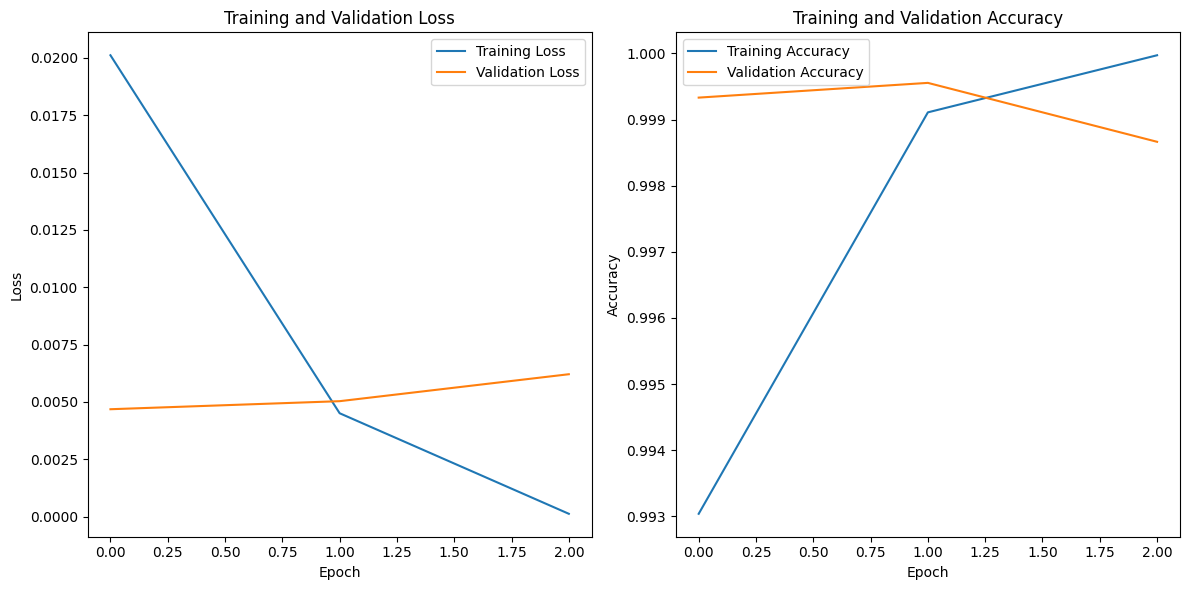

In [59]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## SimpleRNN

In [60]:
from tensorflow.keras.layers import SimpleRNN

epochs = 5
lr = 1e-3
embedding_dim = 300

model = Sequential([
    Input(shape=(max_length,)),
    Embedding(vocab_size, embedding_dim, input_length=max_length, trainable=True),

    Bidirectional(SimpleRNN(128, return_sequences=True)),
    Bidirectional(SimpleRNN(64)),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer = Adam(learning_rate = lr), loss = BinaryCrossentropy(), metrics = ['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 4989, 300)      │    29,549,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 4989, 256)      │       109,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,733,293 (113.42 MB)

 Trainable params: 29,733,293 (113.42 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 2, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')


history = model.fit(train_seq, y_train, epochs = epochs,
                    validation_data = (val_seq , y_val), callbacks = [model_es, model_rlr])

Epoch 1/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 1625s 1s/step - accuracy: 0.9503 - loss: 0.0971 - val_accuracy: 0.9993 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 2/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 1616s 1s/step - accuracy: 0.9994 - loss: 0.0034 - val_accuracy: 0.9996 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 3/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 1615s 1s/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9996 - val_loss: 0.0033 - learning_rate: 2.0000e-04
Epoch 4/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 1615s 1s/step - accuracy: 1.0000 - loss: 1.3762e-04 - val_accuracy: 0.9996 - val_loss: 0.0029 - learning_rate: 2.0000e-04
Epoch 5/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 1614s 1s/step - accuracy: 1.0000 - loss: 2.0533e-05 - val_accuracy: 0.9996 - val_loss: 0.0035 - learning_rate: 2.0000e-04


In [62]:
y_pred_train = np.round(model.predict(train_seq, verbose = 0))
y_pred_test = np.round(model.predict(test_seq, verbose = 0))


print(f'Train Accuracy : {accuracy_score(y_train, y_pred_train) * 100:.2f} %')
print(f'Test Accuracy  : {accuracy_score(y_test, y_pred_test) * 100:.2f} %')

print(f'Classification Report (Train) : \n\n{classification_report(y_train, y_pred_train)}')
print(40*'-')
print(f'\nClassification Report (Test)  : \n\n{classification_report(y_test, y_pred_test)}')

Train Accuracy : 100.00 %
Test Accuracy  : 99.96 %
Classification Report (Train) : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18784
           1       1.00      1.00      1.00     17133

    accuracy                           1.00     35917
   macro avg       1.00      1.00      1.00     35917
weighted avg       1.00      1.00      1.00     35917

----------------------------------------

Classification Report (Test)  : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2357
           1       1.00      1.00      1.00      2134

    accuracy                           1.00      4491
   macro avg       1.00      1.00      1.00      4491
weighted avg       1.00      1.00      1.00      4491



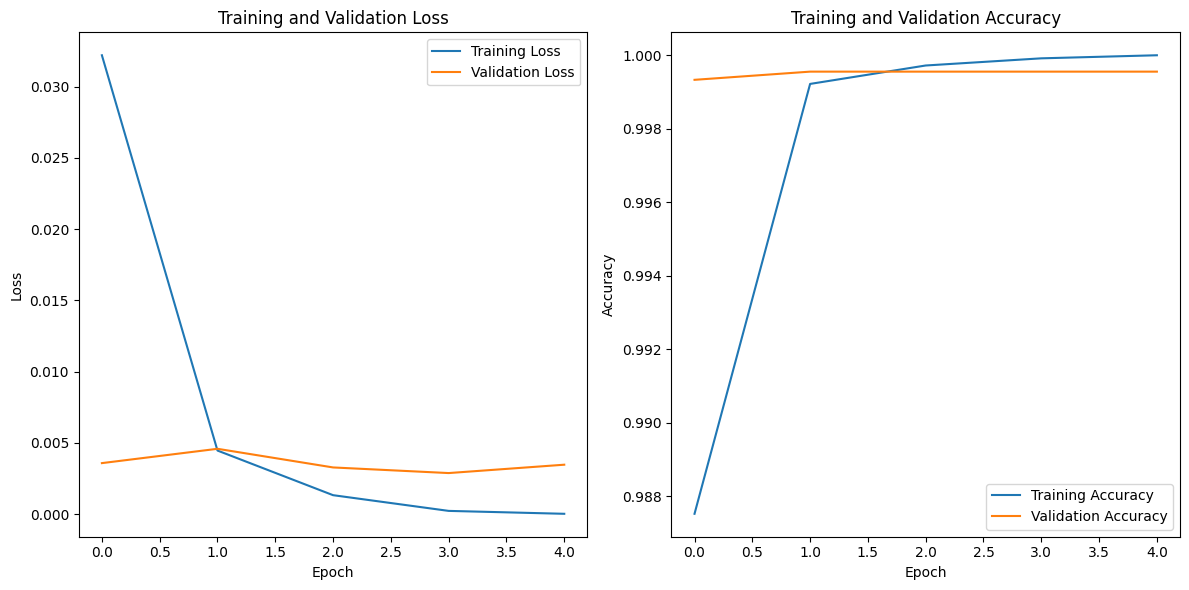

In [63]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

на 1-2% хуже LSTM, но обучаемых параметров в 5 раз меньше

## CNN

In [64]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout, Dense


epochs = 5
lr = 1e-3
embedding_dim = 300

inp = Input(shape=(max_length,))
x = Embedding(vocab_size, embedding_dim, input_length=max_length, trainable=True)(inp)

conv3 = Conv1D(filters=128, kernel_size=3, activation='relu')(x) # используется textCNN с несколькими параллельными Conv1D с разными kernel_size, после чего они объединяются в один вектор
conv4 = Conv1D(filters=128, kernel_size=4, activation='relu')(x)
conv5 = Conv1D(filters=128, kernel_size=5, activation='relu')(x)

pool3 = GlobalMaxPooling1D()(conv3)
pool4 = GlobalMaxPooling1D()(conv4)
pool5 = GlobalMaxPooling1D()(conv5)

merged = Concatenate()([pool3, pool4, pool5])
merged = Dropout(0.2)(merged)

dense = Dense(256, activation='relu')(merged)
dense = Dropout(0.5)(dense)

out = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=inp, outputs=out)

model.compile(optimizer=Adam(learning_rate=lr), loss=BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 4989)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 4989, 300) │ 29,549,100 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 4987, 128) │    115,328 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 4986, 128) │    153,728 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 4985, 128) │    192,128 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │     98,560 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        257 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,109,101 (114.86 MB)

 Trainable params: 30,109,101 (114.86 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 2, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')


history = model.fit(train_seq, y_train, epochs = epochs,
                    validation_data = (val_seq , y_val), callbacks = [model_es, model_rlr])

Epoch 1/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 293s 247ms/step - accuracy: 0.9529 - loss: 0.0988 - val_accuracy: 0.9951 - val_loss: 0.0145 - learning_rate: 0.0010
Epoch 2/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 266s 237ms/step - accuracy: 0.9991 - loss: 0.0031 - val_accuracy: 0.9989 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 3/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 266s 237ms/step - accuracy: 0.9992 - loss: 0.0035 - val_accuracy: 0.9973 - val_loss: 0.0217 - learning_rate: 0.0010
Epoch 4/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 266s 237ms/step - accuracy: 0.9996 - loss: 7.1632e-04 - val_accuracy: 0.9984 - val_loss: 0.0122 - learning_rate: 2.0000e-04


In [66]:
y_pred_train = np.round(model.predict(train_seq, verbose = 0))
y_pred_test = np.round(model.predict(test_seq, verbose = 0))


print(f'Train Accuracy : {accuracy_score(y_train, y_pred_train) * 100:.2f} %')
print(f'Test Accuracy  : {accuracy_score(y_test, y_pred_test) * 100:.2f} %')

print(f'Classification Report (Train) : \n\n{classification_report(y_train, y_pred_train)}')
print(40*'-')
print(f'\nClassification Report (Test)  : \n\n{classification_report(y_test, y_pred_test)}')

Train Accuracy : 99.95 %
Test Accuracy  : 99.84 %
Classification Report (Train) : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18784
           1       1.00      1.00      1.00     17133

    accuracy                           1.00     35917
   macro avg       1.00      1.00      1.00     35917
weighted avg       1.00      1.00      1.00     35917

----------------------------------------

Classification Report (Test)  : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2357
           1       1.00      1.00      1.00      2134

    accuracy                           1.00      4491
   macro avg       1.00      1.00      1.00      4491
weighted avg       1.00      1.00      1.00      4491



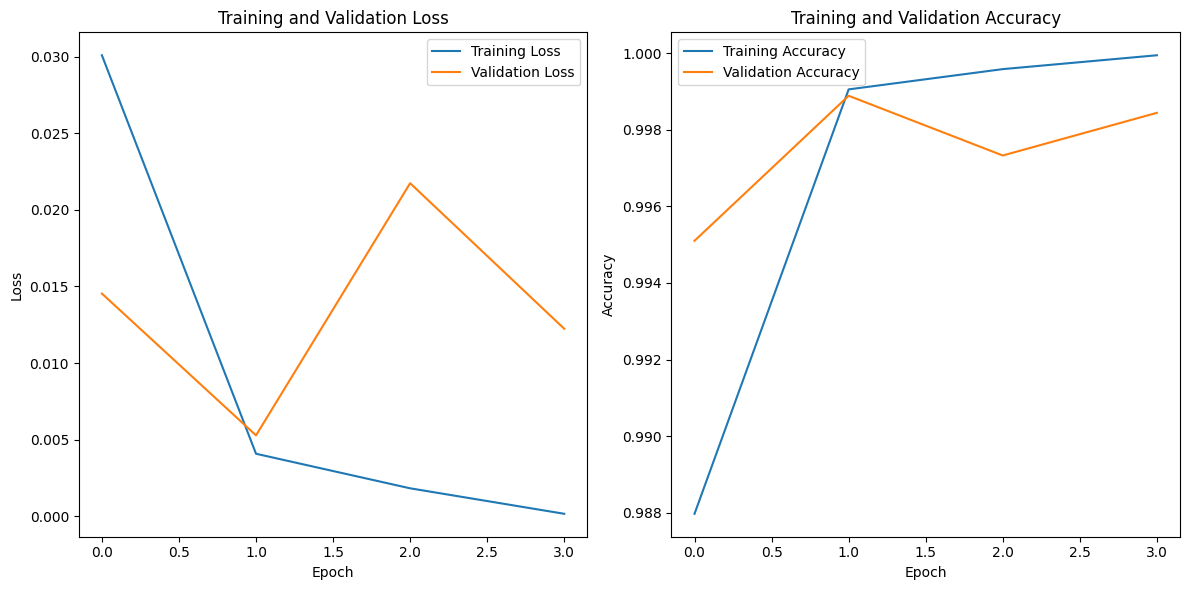

In [67]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Предобученные эмбеддинги

In [68]:
! pip install sentence-transformers tf-keras

In [69]:
from sentence_transformers import SentenceTransformer
from catboost import CatBoostClassifier

In [70]:
model_emb = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]